In [14]:
import random
import numpy as np
import pandas as pd
import pulp
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, LpMaximize
import matplotlib.pyplot as plt

In [15]:
def generate_random_number(seed,begin,end):
    random.seed(seed)  # Set the random seed
    return random.randint(begin, end)



In [16]:
seed = 614 #0614 -> Danick's id 20880614

In [17]:
def generate_instance(n_orders,n_itemtypes,n_totes,max_item_quantity=3)->dict:

    order_itemtypes = [[] for _ in range(n_orders)]  # Initialize an empty list of lists
    order_quantities = [[] for _ in range(n_orders)]
    for i in range(n_orders):
        order_size = random.randint(1, 3)

        tt = random.sample(range(1, n_itemtypes+1), order_size)
        qq = [random.randint(1, max_item_quantity) for _ in range(order_size)]
        order_itemtypes[i] = (tt)
        order_quantities[i] = (qq)

    orders_totes = [[] for _ in range(n_orders)]
    for i in range(n_orders):
        for j in range(len(order_itemtypes[i])):
            if j == 0:
                orders_totes[i].append(random.randint(1, n_totes))
            else:
                if random.randint(0, 1) == 0:
                    orders_totes[i].append(orders_totes[i][0])
                else:
                    orders_totes[i].append(random.randint(1, n_totes))

    return {
        'orders':[x for x in range(1,1+n_orders)],
        'item_types':[x for x in range(1,1+n_itemtypes)],
        'totes':[x for x in range(1,1+n_totes)],
        'order_item_types':order_itemtypes,
        'order_item_quantities':order_quantities,
        'order_item_totes':orders_totes
    }

In [18]:
large_instances=[
    generate_instance(
        n_orders=generate_random_number(seed,10,15),
        n_itemtypes=generate_random_number(seed,7,10),
        n_totes=generate_random_number(seed,15,20)
    )
    for _ 
    in range(10)
]

In [34]:
class Model:
    def __init__(
        self,
        orders,
        totes,
        order_item_totes,
        order_item_quantities,
        order_item_types,
        item_types,
        use_heuristic=False
    ):
        self.K = orders
        self.J = totes
        self.J0 = [0]+totes
        self.Jn1 = totes+[len(totes)+1]
        self.Jk = order_item_totes

        self.order_item_types = order_item_types
        self.order_item_quantities = order_item_quantities
        self.item_types = item_types

        self.tote_content = [[] for _ in range(len(totes))]
        for order_i, _ in enumerate(order_item_totes):
            for (
                order_item_i, order_item_quantity
            ) in enumerate(order_item_quantities[order_i]):
                self.tote_content[
                    order_item_totes[order_i][order_item_i] -1
                ] += [
                    order_item_types[order_i][order_item_i]
                ]*order_item_quantity

        #self.p = [max(0.01,len(tote)) for tote in self.tote_content]
        self.p = [len(tote) for tote in self.tote_content]

        self.M = sum(len(tote) for tote in self.tote_content) + 1

        self._initiate_model(use_heuristic)

    def _initiate_model(self, use_heuristic=False):

        self.model = LpProblem(sense=LpMinimize)

        # xij
        self.x = [
            [
                LpVariable(f'x_i{i}_j{j}', lowBound=0, cat='Binary')
                for j in range(len(self.J)+2)
            ]
            for i in range(len(self.J)+2)
        ]
        
        # cj
        self.c = [LpVariable(f'c_j{j}', lowBound=0) for j in self.J]
        
        # cok
        self.co = [LpVariable(f'co_j{k}', lowBound=0) for k in self.K]
        
        # objective
        self.model += lpSum(self.co[k_i] for k_i, k in enumerate(self.K))
        
        # constraint 1 -> all totes must be used
        for j in self.J:
            self.model += lpSum(self.x[i][j] for i in self.J0) == 1
        
        # constraint 2 -> one induction line
        self.model += lpSum(self.x[0][j] for j in self.J) == 1
        
        # constraint 3 -> all preceded tote must precede
        for j in self.J:
            self.model += lpSum(
                self.x[i][j] for i in self.J0
            )-lpSum(
                self.x[j][i] for i in self.Jn1
            ) == 0
        
        # constraint 4 -> first tote completion time is it's own
        for j_i, j in enumerate(self.J):
            self.model += self.c[j_i] >= self.p[j_i]*self.x[0][j]
        
        # constraint 5 -> tote completion time is itself plus all preceding
        for j_i, j in enumerate(self.J):
            for i_i, i in enumerate(self.J):
                self.model += self.c[j_i] >= (
                    (self.c[i_i]+self.p[j_i])-self.M*(1-self.x[i][j])
                )
        
        # constraint 6 -> order completion is its latest completed tote
        for k_i, k in enumerate(self.K):
            for tote in self.Jk[k_i]:
                self.model += self.co[k_i] >= self.c[tote-1]

        if use_heuristic:
            order_tote_count=[len(order_totes) for order_totes in self.Jk]
            max_tote_count=max(order_tote_count)

            #add totes of orders with the fewest tote first
            solution=[]
            for tote_count in range(1,max_tote_count+1):
                for order_totes in self.Jk:
                    if len(order_totes)==tote_count:
                        for tote in order_totes:
                            if not tote in solution:
                                solution.append(tote)
            #add empty totes at the end
            for empty_tote in [
                tote for tote in self.J if tote not in solution
            ]:
                solution.append(empty_tote)

            prev=0
            for tote in solution:
                self.model += self.x[prev][tote] == 1 
                prev=tote
            self.model += self.x[prev][self.Jn1[-1]] == 1

    def inject_solution(self,solution):
        for i in range(1,len(solution)):
            self.model += self.x[solution[i-1]][solution[i]] == 1
        self.model+= self.x[0][solution[0]] == 1
        self.model+= self.x[solution[-1]][len(solution)+1] == 1


    def solve(self, solver=pulp.getSolver('CPLEX_CMD')):
        self.model.solve(solver=solver)

        print('Objective: ' + str(pulp.value(self.model.objective)))

    def reset_model(self):
        self._initiate_model()

    @property
    def objective(self):
        return round(pulp.value(self.model.objective))
    
    def _value(self,x):
            v=pulp.value(x)
            if v:
                return round(v)
            else:
                return 0
    
    def get_x_value(self):
        
            
        x = [
            [
                self._value(self.x[i][j])
                for j in range(len(self.J)+2)
            ]
            for i in range(len(self.J)+2)
        ]

        return x
    
    def get_co_value(self):
        return [self._value(self.co[k_i]) for k_i,_ in enumerate(self.K)]
    
    def get_c_value(self):
        return [self._value(self.c[j_i]) for j_i,_ in enumerate(self.J)]

    @property
    def solution(self):
        """
        Returns the order of the totes first one on the left.
        """
        x = self.get_x_value()

        totes = []

        next = 0
        while next != self.Jn1[-1]:
            index = x[next].index(1)
            totes.append(index)
            next = index

        return totes[:-1]


In [35]:
large_instances[0]

{'orders': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 'item_types': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 'totes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 'order_item_types': [[4],
  [2, 9, 1],
  [3, 7, 4],
  [6, 7],
  [6, 4, 2],
  [9, 8],
  [7, 2, 4],
  [1, 3],
  [9, 3, 2],
  [4],
  [6],
  [8, 1, 9]],
 'order_item_quantities': [[1],
  [3, 1, 1],
  [1, 2, 3],
  [2, 2],
  [1, 3, 1],
  [2, 1],
  [2, 2, 3],
  [1, 2],
  [3, 1, 2],
  [2],
  [1],
  [3, 3, 2]],
 'order_item_totes': [[13],
  [15, 15, 15],
  [11, 3, 11],
  [7, 7],
  [17, 13, 10],
  [7, 14],
  [5, 7, 5],
  [14, 17],
  [5, 15, 5],
  [17],
  [5],
  [4, 4, 4]]}

In [44]:
optimal_objectives=[]
random_objectives=[]

for instance in large_instances:
    model = Model(**instance)
    #model.solve(solver=pulp.PULP_CBC_CMD(timeLimit=30, msg=False))
    model.solve(solver=pulp.get_solver('CPLEX_CMD', timeLimit=30))
    print('done')
    optimal_objectives.append(model.objective)

    # take the average of 10 random instance
    objs=[]
    for _ in range(10):
        model = Model(**instance)
        model.inject_solution(random.sample(instance['totes'],len(instance['totes'])))
        model.solve()
        objs.append(model.objective)

    random_objectives.append(sum(objs)/10)


Objective: 306.99999999400006
done
Objective: 381.0
Objective: 413.0
Objective: 433.0
Objective: 402.0
Objective: 428.0
Objective: 446.0
Objective: 386.0
Objective: 408.0
Objective: 383.0
Objective: 350.0
Objective: 305.0
done
Objective: 412.0
Objective: 394.0
Objective: 427.0
Objective: 402.0
Objective: 440.0
Objective: 430.0
Objective: 383.0
Objective: 384.0
Objective: 426.0
Objective: 411.0
Objective: 307.0
done
Objective: 428.0
Objective: 386.0
Objective: 382.0
Objective: 444.0
Objective: 356.0
Objective: 401.0
Objective: 424.0
Objective: 405.0
Objective: 416.0
Objective: 420.0
Objective: 305.0
done
Objective: 394.0
Objective: 359.0
Objective: 423.0
Objective: 391.0
Objective: 424.0
Objective: 390.0
Objective: 418.0
Objective: 419.0
Objective: 361.0
Objective: 351.0
Objective: 305.0
done
Objective: 431.0
Objective: 396.0
Objective: 392.0
Objective: 427.0
Objective: 312.0
Objective: 375.0
Objective: 458.0
Objective: 417.0
Objective: 369.0
Objective: 401.0
Objective: 305.0
done
Objec

In [45]:
results=[]
for i, optimal,rand in zip([x for x in range(len(optimal_objectives))],optimal_objectives,random_objectives):
    results.append({
            'Instance': i+1,
            'Optimal Objective': optimal,
            'Random Objective': rand,
            'Improvement (%)': ((optimal - rand) / rand) * 100
        })


Comparison of Optimal vs Random Ordering:
   Instance  Optimal Objective  Random Objective  Improvement (%)
0         1                307             403.0       -23.821340
1         2                305             410.9       -25.772694
2         3                307             406.2       -24.421467
3         4                305             393.0       -22.391858
4         5                305             397.8       -23.328306
5         6                305             401.7       -24.072691
6         7                305             392.0       -22.193878
7         8                305             397.9       -23.347575
8         9                307             404.1       -24.028706
9        10                305             411.9       -25.952901

Variance of Objective Values: 0.84


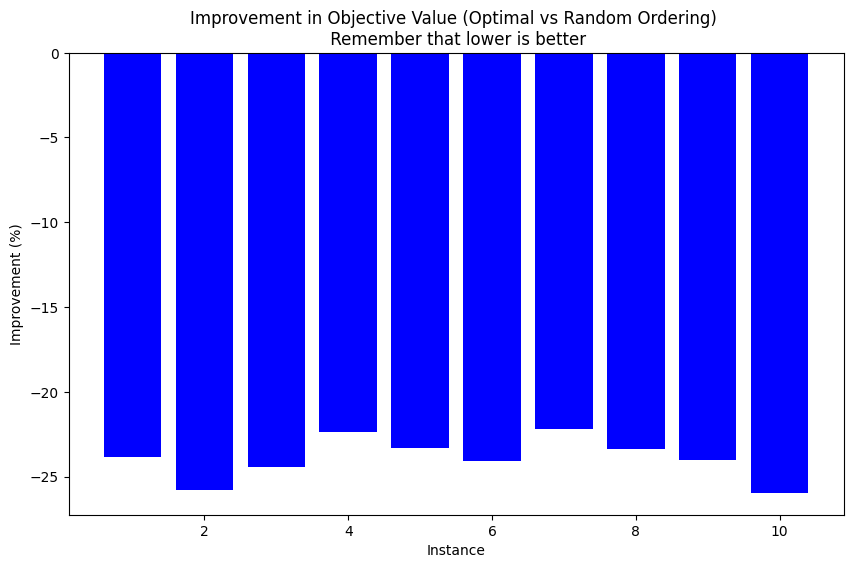

In [47]:
print("\nComparison of Optimal vs Random Ordering:")
results_df = pd.DataFrame(results)
print(results_df)

# Calculate and print variance of objective values
variance_objective = np.var(results_df['Optimal Objective'])
print(f"\nVariance of Objective Values: {variance_objective:.2f}")

# Plot the improvement
plt.figure(figsize=(10, 6))
plt.bar(results_df['Instance'], results_df['Improvement (%)'], color='blue')
plt.xlabel('Instance')
plt.ylabel('Improvement (%)')
plt.title('Improvement in Objective Value (Optimal vs Random Ordering) \n Remember that lower is better')
plt.show()